In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib


In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")



Dataset shape: (7043, 21)

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

In [3]:
# 2. DATA CLEANING
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


In [5]:
# Fill missing TotalCharges with 0 (customers with 0 tenure)

df['TotalCharges'] = df['TotalCharges'].fillna(0)


In [6]:
# Remove impossible billing values (0 tenure should have 0 total charges)
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0


In [7]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [8]:
print("\nMissing values after cleaning:")
print(df.isnull().sum())



Missing values after cleaning:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [9]:
# 3. OUTLIER HANDLING
def cap_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return col.clip(lower, upper)

df['MonthlyCharges'] = cap_outliers(df['MonthlyCharges'])
df['TotalCharges'] = cap_outliers(df['TotalCharges'])


In [10]:
# 4. FEATURE ENGINEERING 


In [11]:
df['tenure_bucket'] = pd.cut(
    df['tenure'],
    bins=[0, 6, 12, 24, 60, 100],
    labels=['0-6', '6-12', '12-24', '24-60', '60+']
)


In [12]:
df['tenure_risk'] = pd.cut(
    df['tenure'],
    bins=[-1, 3, 6, 12, 24, 100],
    labels=[5, 4, 3, 2, 1],
    include_lowest=True
).astype(int)


In [13]:
df['charge_pressure'] = df['MonthlyCharges'] / (df['tenure'] + 1)


In [14]:
df['relative_price'] = (
    df['MonthlyCharges'] > 
    df.groupby('Contract')['MonthlyCharges'].transform('median')
).astype(int)


In [16]:
# Protection gap (count of missing protection services)
protection_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df['protection_gap'] = df[protection_services].apply(
    lambda x: (x == 'No').sum(), axis=1
)

In [17]:
# Contract risk
contract_map = {'Month-to-month': 3, 'One year': 2, 'Two year': 1}
df['contract_risk'] = df['Contract'].map(contract_map)


In [18]:
# Payment risk
payment_risk = {
    'Electronic check': 3,
    'Mailed check': 2,
    'Bank transfer (automatic)': 1,
    'Credit card (automatic)': 1
}
df['payment_risk'] = df['PaymentMethod'].map(payment_risk)


In [19]:
# Service complexity
service_cols = ['PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies']
df['service_complexity'] = df[service_cols].apply(
    lambda x: (x != 'No').sum(), axis=1
)


In [20]:
# Engagement score
df['engagement_score'] = df['TotalCharges'] / (df['MonthlyCharges'] * (df['tenure'] + 1) + 0.01)


In [21]:
# Early warning score (composite risk metric)
df['early_warning_score'] = (
    df['tenure_risk'] * 0.25 +
    df['contract_risk'] * 0.25 +
    df['payment_risk'] * 0.20 +
    df['protection_gap'] * 0.15 +
    df['relative_price'] * 0.15
) * 20


In [23]:
# Early warning flag
df['early_warning_flag'] = (df['early_warning_score'] >= 60).astype(int)




In [24]:
# 5. EXPLORATORY ANALYSIS


In [25]:
print("\n=== CHURN ANALYSIS ===")
print(f"Overall churn rate: {df['Churn'].mean():.2%}")



=== CHURN ANALYSIS ===
Overall churn rate: 26.54%


In [26]:
print("\nChurn by tenure bucket:")
print(df.groupby('tenure_bucket')['Churn'].mean())



Churn by tenure bucket:
tenure_bucket
0-6      0.533333
6-12     0.358865
12-24    0.287109
24-60    0.183430
60+      0.066098
Name: Churn, dtype: float64


In [27]:
print("\nChurn by contract type:")
print(pd.crosstab(df['Contract'], df['Churn'], normalize='index'))



Churn by contract type:
Churn                  0         1
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319


In [28]:
print("\nChurn by payment method:")
print(df.groupby('PaymentMethod')['Churn'].mean().sort_values(ascending=False))



Churn by payment method:
PaymentMethod
Electronic check             0.452854
Mailed check                 0.191067
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Name: Churn, dtype: float64


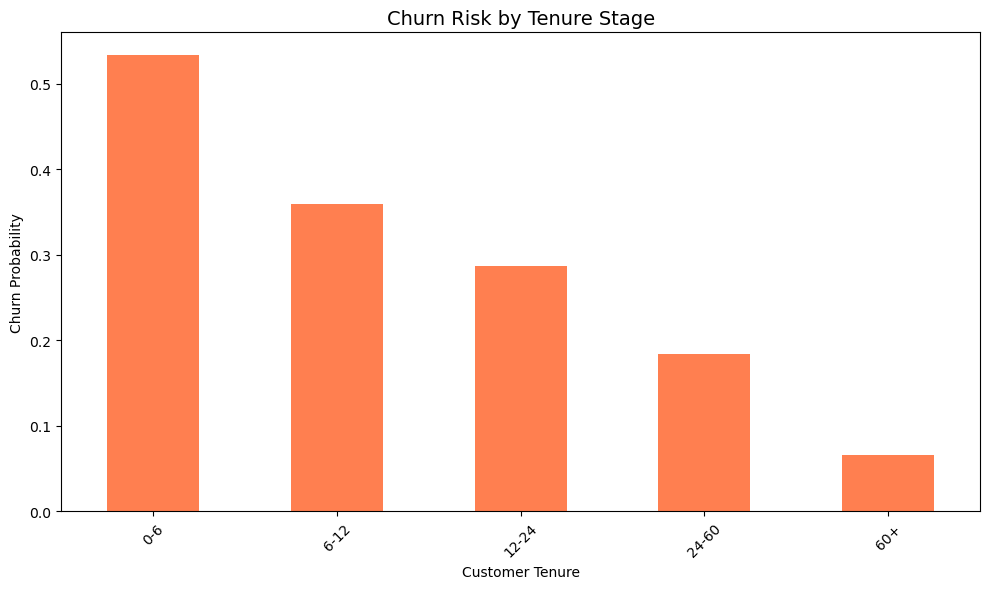

In [29]:
# Visualize tenure risk
tenure_churn = df.groupby('tenure_bucket')['Churn'].mean()
plt.figure(figsize=(10, 6))
tenure_churn.plot(kind='bar', color='coral')
plt.title('Churn Risk by Tenure Stage', fontsize=14)
plt.ylabel('Churn Probability')
plt.xlabel('Customer Tenure')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


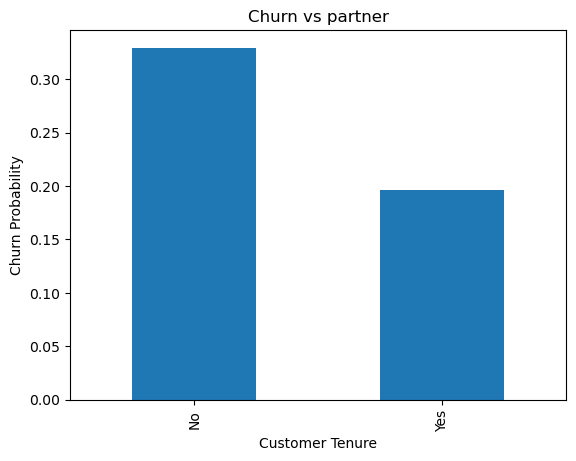

In [60]:
import matplotlib.pyplot as plt

tenure_churn = df.groupby('Partner')['Churn'].mean()

tenure_churn.plot(kind='bar')
plt.title('Churn vs partner')
plt.ylabel('Churn Probability')
plt.xlabel('Customer Tenure')
plt.show()


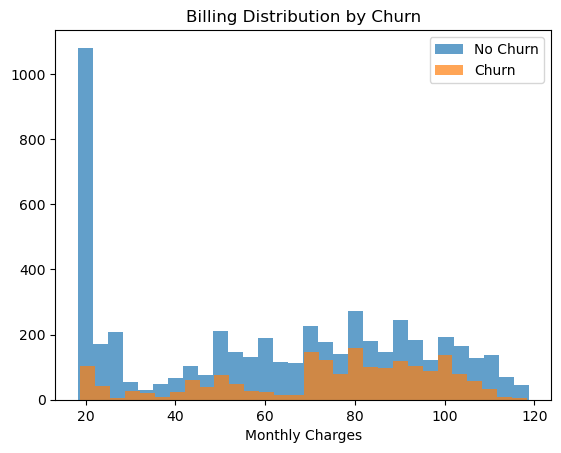

In [61]:
#Detects billing shock visually
plt.hist(df[df['Churn']==0]['MonthlyCharges'], bins=30, alpha=0.7, label='No Churn')
plt.hist(df[df['Churn']==1]['MonthlyCharges'], bins=30, alpha=0.7, label='Churn')
plt.legend()
plt.xlabel('Monthly Charges')
plt.title('Billing Distribution by Churn')
plt.show()


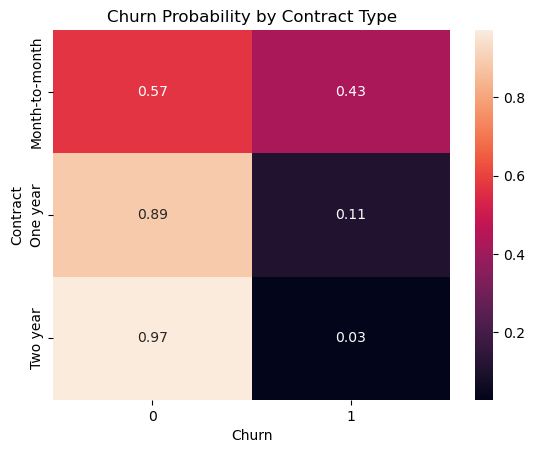

In [62]:
#Contract × Churn Heatmap
import seaborn as sns

contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index')

sns.heatmap(contract_churn, annot=True, fmt='.2f')
plt.title('Churn Probability by Contract Type')
plt.show()


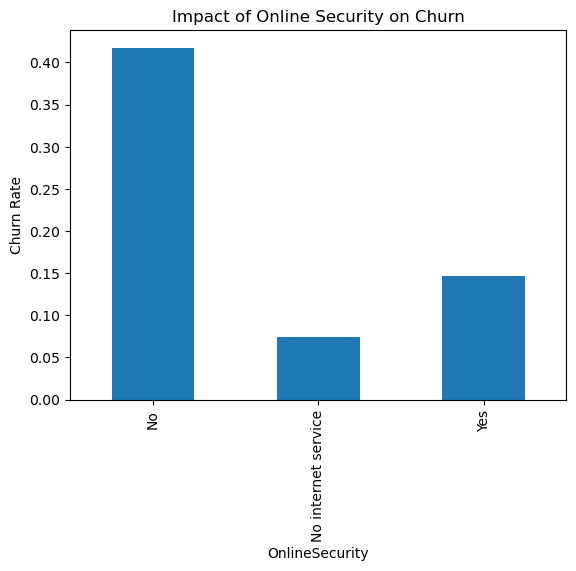

In [63]:
#add-on services reduce churn
service_churn = df.groupby('OnlineSecurity')['Churn'].mean()

service_churn.plot(kind='bar')
plt.title('Impact of Online Security on Churn')
plt.ylabel('Churn Rate')
plt.show()


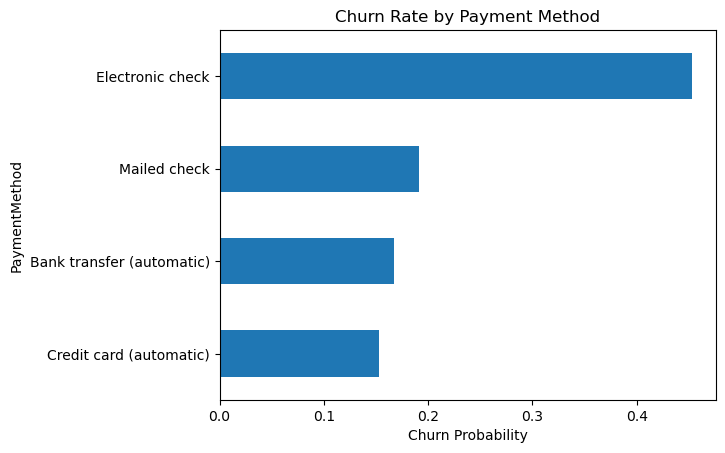

In [64]:
#Electronic check = highest churn


payment_churn = df.groupby('PaymentMethod')['Churn'].mean().sort_values()

payment_churn.plot(kind='barh')
plt.title('Churn Rate by Payment Method')
plt.xlabel('Churn Probability')
plt.show()


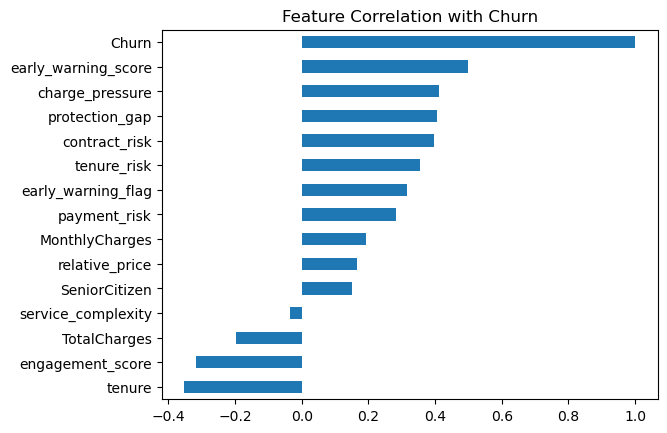

In [65]:
corr = df.corr(numeric_only=True)['Churn'].sort_values()

corr.plot(kind='barh')
plt.title('Feature Correlation with Churn')
plt.show()


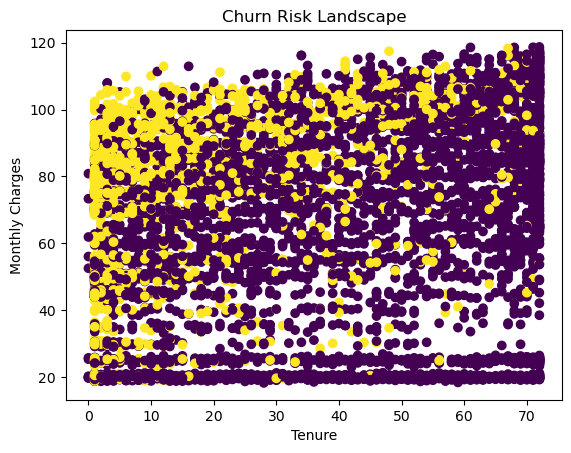

In [66]:
#Risk Segmentation Scatter
plt.scatter(df['tenure'], df['MonthlyCharges'], c=df['Churn'])
plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')
plt.title('Churn Risk Landscape')
plt.show()


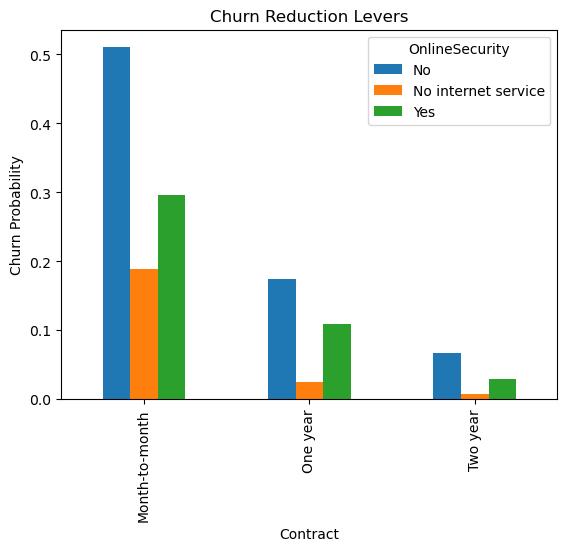

In [67]:
#Visualizes what changes reduce churn
df.groupby(['Contract','OnlineSecurity'])['Churn'].mean().unstack().plot(kind='bar')
plt.title('Churn Reduction Levers')
plt.ylabel('Churn Probability')
plt.show()



In [30]:
# 6. PREPARE DATA FOR MODELING


In [31]:
# Define categorical and numeric columns (FIXED LIST)
cat_cols = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

num_cols = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
    'tenure_risk', 'charge_pressure', 'relative_price',
    'protection_gap', 'contract_risk', 'payment_risk',
    'service_complexity', 'engagement_score'
]


In [32]:
# Create a copy for modeling (exclude customerID and Churn)
df_model = df.copy()


In [33]:
# Initialize encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


In [34]:
# Fit and transform categorical columns
encoded = encoder.fit_transform(df_model[cat_cols])


In [35]:
# Create DataFrame with encoded columns
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(cat_cols),
    index=df_model.index
)


In [36]:
# Combine numeric and encoded categorical
df_final = pd.concat([
    df_model[num_cols],
    encoded_df
], axis=1)



In [37]:
df_final['Churn'] = df_model['Churn']

print("\nFinal dataset shape:", df_final.shape)
print("Columns:", df_final.columns.tolist()[:10], "...")



Final dataset shape: (7043, 39)
Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_risk', 'charge_pressure', 'relative_price', 'protection_gap', 'contract_risk', 'payment_risk'] ...


In [38]:
# 8. TRAIN-TEST SPLIT


In [39]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Training set: (5634, 38)
Test set: (1409, 38)


In [40]:
# 9. MODEL TRAINING


In [41]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Store trained feature names
TRAIN_FEATURES = model.feature_names_in_

print("\nModel trained successfully!")
print(f"Number of features: {len(TRAIN_FEATURES)}")



Model trained successfully!
Number of features: 38


In [42]:
# 10. MODEL EVALUATION


In [43]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [45]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("\n=== MODEL PERFORMANCE ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")




=== MODEL PERFORMANCE ===
Accuracy:  0.808
Precision: 0.672
Recall:    0.543
F1 Score:  0.601


In [46]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [47]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))




Confusion Matrix:
[[936  99]
 [171 203]]


In [48]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': TRAIN_FEATURES,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print("\nTop 10 Churn Risk Factors:")
print(feature_importance.head(10))

print("\nTop 10 Protective Factors:")
print(feature_importance.tail(10))



Top 10 Churn Risk Factors:
                           feature  coefficient
18     InternetService_Fiber optic     0.595910
31             StreamingMovies_Yes     0.407829
34            PaperlessBilling_Yes     0.402714
8                    contract_risk     0.395524
29                 StreamingTV_Yes     0.393896
17               MultipleLines_Yes     0.349554
6                   relative_price     0.323189
36  PaymentMethod_Electronic check     0.269923
0                    SeniorCitizen     0.173374
16  MultipleLines_No phone service     0.139829

Top 10 Protective Factors:
                                  feature  coefficient
35  PaymentMethod_Credit card (automatic)    -0.177775
23                       OnlineBackup_Yes    -0.185319
10                     service_complexity    -0.201008
14                         Dependents_Yes    -0.263073
32                      Contract_One year    -0.343990
27                        TechSupport_Yes    -0.410183
11                       engage

In [49]:
# 11. PREDICTION FUNCTION


In [50]:

def predict_churn_prob(customer_row):
    """
    Predict churn probability for a single customer
    
    Parameters:
    customer_row: dict or pandas Series with customer data
    
    Returns:
    float: churn probability (0 to 1)
    """
    # Convert to DataFrame
    if isinstance(customer_row, dict):
        row_df = pd.DataFrame([customer_row])
    else:
        row_df = pd.DataFrame([customer_row.to_dict()])
    
    # Feature engineering for new customer
    row_df['tenure_risk'] = pd.cut(
        row_df['tenure'],
        bins=[-1, 3, 6, 12, 24, 100],
        labels=[5, 4, 3, 2, 1],
        include_lowest=True
    ).astype(int)[0]
    
    row_df['charge_pressure'] = row_df['MonthlyCharges'] / (row_df['tenure'] + 1)
    row_df['relative_price'] = 0  # Simplified for single prediction
    
    # Protection gap
    prot_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
    if all(col in row_df.columns for col in prot_cols):
        row_df['protection_gap'] = (row_df[prot_cols] == 'No').sum(axis=1).values[0]
    else:
        row_df['protection_gap'] = 0
    
    row_df['contract_risk'] = row_df['Contract'].map(contract_map).values[0]
    row_df['payment_risk'] = row_df['PaymentMethod'].map(payment_risk).values[0]
    
    # Service complexity
    serv_cols = ['PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies']
    if all(col in row_df.columns for col in serv_cols):
        row_df['service_complexity'] = (row_df[serv_cols] != 'No').sum(axis=1).values[0]
    else:
        row_df['service_complexity'] = 0
    
    row_df['engagement_score'] = row_df['TotalCharges'] / (row_df['MonthlyCharges'] * (row_df['tenure'] + 1) + 0.01)
    
    # Encode categorical features
    row_encoded = encoder.transform(row_df[cat_cols])
    encoded_df = pd.DataFrame(
        row_encoded,
        columns=encoder.get_feature_names_out(cat_cols),
        index=row_df.index
    )
    
    # Combine numeric + encoded
    final_row = pd.concat([
        row_df[num_cols],
        encoded_df
    ], axis=1)
    
    # Align with training features
    final_row = final_row.reindex(columns=TRAIN_FEATURES, fill_value=0)
    
    return model.predict_proba(final_row)[0][1]

In [51]:
# 12. COUNTERFACTUAL RETENTION SYSTEM


In [52]:

# Action costs (monthly cost to company)
ACTION_COSTS = {
    'Reduce ₹50': 50,
    'Reduce ₹100': 100,
    'Reduce ₹200': 200,
    'Add Online Security': 30,
    'Add Tech Support': 40,
    'Switch to Auto-pay': 10,
    'Upgrade to 1-year Contract': 80
}

def generate_cost_aware_counterfactual(customer):
    """
    Generate retention strategies with cost-benefit analysis
    
    Parameters:
    customer: dict or Series with customer data
    
    Returns:
    DataFrame with recommended actions ranked by effectiveness
    """
    if isinstance(customer, pd.Series):
        customer = customer.to_dict()
    
    results = []
    base_prob = predict_churn_prob(customer)
    
    # Price reductions
    for reduction in [50, 100, 200]:
        temp = customer.copy()
        temp['MonthlyCharges'] = max(0, temp['MonthlyCharges'] - reduction)
        temp['TotalCharges'] = temp['MonthlyCharges'] * temp['tenure']
        new_prob = predict_churn_prob(temp)
        
        results.append({
            'action': f'Reduce ₹{reduction}',
            'new_prob': new_prob,
            'risk_drop': base_prob - new_prob,
            'cost': ACTION_COSTS[f'Reduce ₹{reduction}']
        })
    
    # Add services
    if customer.get('OnlineSecurity', 'Yes') == 'No':
        temp = customer.copy()
        temp['OnlineSecurity'] = 'Yes'
        new_prob = predict_churn_prob(temp)
        
        results.append({
            'action': 'Add Online Security',
            'new_prob': new_prob,
            'risk_drop': base_prob - new_prob,
            'cost': ACTION_COSTS['Add Online Security']
        })
    
    if customer.get('TechSupport', 'Yes') == 'No':
        temp = customer.copy()
        temp['TechSupport'] = 'Yes'
        new_prob = predict_churn_prob(temp)
        
        results.append({
            'action': 'Add Tech Support',
            'new_prob': new_prob,
            'risk_drop': base_prob - new_prob,
            'cost': ACTION_COSTS['Add Tech Support']
        })
    
    # Payment method change
    if customer.get('PaymentMethod') == 'Electronic check':
        temp = customer.copy()
        temp['PaymentMethod'] = 'Credit card (automatic)'
        new_prob = predict_churn_prob(temp)
        
        results.append({
            'action': 'Switch to Auto-pay',
            'new_prob': new_prob,
            'risk_drop': base_prob - new_prob,
            'cost': ACTION_COSTS['Switch to Auto-pay']
        })
    
    # Contract upgrade
    if customer.get('Contract') == 'Month-to-month':
        temp = customer.copy()
        temp['Contract'] = 'One year'
        new_prob = predict_churn_prob(temp)
        
        results.append({
            'action': 'Upgrade to 1-year Contract',
            'new_prob': new_prob,
            'risk_drop': base_prob - new_prob,
            'cost': ACTION_COSTS['Upgrade to 1-year Contract']
        })
    
    # Convert to DataFrame
    cf_df = pd.DataFrame(results)
    
    # ROI score (risk reduction per dollar spent)
    cf_df['roi_score'] = cf_df['risk_drop'] / cf_df['cost']
    
    return cf_df.sort_values(by=['new_prob', 'cost'], ascending=[True, True])


In [53]:
# 13. TEST THE SYSTEM


In [55]:
# Pick a high-risk customer
high_risk_customers = df[df['early_warning_flag'] == 1]
if len(high_risk_customers) > 0:
    test_customer = high_risk_customers.iloc[0]
    
    print("\n=== HIGH-RISK CUSTOMER ANALYSIS ===")
    print(f"Customer ID: {test_customer.get('customerID', 'Unknown')}")
    print(f"Tenure: {test_customer['tenure']} months")
    print(f"Monthly Charges: ₹{test_customer['MonthlyCharges']}")
    print(f"Contract: {test_customer['Contract']}")
    print(f"Payment Method: {test_customer['PaymentMethod']}")
    
    base_churn_prob = predict_churn_prob(test_customer)
    print(f"\nBase Churn Probability: {base_churn_prob:.1%}")





=== HIGH-RISK CUSTOMER ANALYSIS ===
Customer ID: 7590-VHVEG
Tenure: 1 months
Monthly Charges: ₹29.85
Contract: Month-to-month
Payment Method: Electronic check

Base Churn Probability: 75.5%


In [56]:
    
    print("\n=== RETENTION RECOMMENDATIONS ===")
    recommendations = generate_cost_aware_counterfactual(test_customer)
    print(recommendations)
    
    # Best action
    TARGET_CHURN_PROB = 0.30
    filtered = recommendations[recommendations['new_prob'] <= TARGET_CHURN_PROB]
    
    if len(filtered) > 0:
        best_action = filtered.iloc[0]
        print(f"\n✅ BEST ACTION: {best_action['action']}")
        print(f"   New Churn Risk: {best_action['new_prob']:.1%}")
        print(f"   Risk Reduction: {best_action['risk_drop']:.1%}")
        print(f"   Monthly Cost: ₹{best_action['cost']}")
        print(f"   ROI Score: {best_action['roi_score']:.4f}")
    else:
        print("\n⚠️ No single action brings churn below 30%. Consider combining strategies.")



=== RETENTION RECOMMENDATIONS ===
                       action  new_prob  risk_drop  cost  roi_score
6  Upgrade to 1-year Contract  0.594684   0.159838    80   0.001998
5          Switch to Auto-pay  0.665149   0.089373    10   0.008937
3         Add Online Security  0.674278   0.080244    30   0.002675
4            Add Tech Support  0.687104   0.067418    40   0.001685
0                  Reduce ₹50  0.726233   0.028289    50   0.000566
1                 Reduce ₹100  0.726233   0.028289   100   0.000283
2                 Reduce ₹200  0.726233   0.028289   200   0.000141

⚠️ No single action brings churn below 30%. Consider combining strategies.


In [58]:
joblib.dump(model, "churn_model.pkl")
joblib.dump(encoder, "encoder.pkl")
joblib.dump(cat_cols, "cat_cols.pkl")
joblib.dump(TRAIN_FEATURES, "train_features.pkl")

print("\n✅ Models saved successfully!")
print("   - churn_model.pkl")
print("   - encoder.pkl")
print("   - cat_cols.pkl")
print("   - train_features.pkl")




✅ Models saved successfully!
   - churn_model.pkl
   - encoder.pkl
   - cat_cols.pkl
   - train_features.pkl


In [ ]:
# 15. PRODUCTION-READY API SIMULATION


In [59]:

def churn_api_simulation(customer_dict):
    """
    Production-ready API endpoint simulation
    
    Input: customer dictionary
    Output: churn prediction + actionable recommendations
    """
    prob = predict_churn_prob(customer_dict)
    
    if prob < 0.3:
        band = "Low Risk"
    elif prob < 0.6:
        band = "Medium Risk"
    else:
        band = "High Risk"
    
    # Generate recommendations if high risk
    recommendations = []
    if prob >= 0.5:
        actions_df = generate_cost_aware_counterfactual(customer_dict)
        top_actions = actions_df.head(3)
        
        for _, row in top_actions.iterrows():
            recommendations.append({
                'action': row['action'],
                'new_churn_prob': round(row['new_prob'], 3),
                'cost': row['cost'],
                'roi_score': round(row['roi_score'], 4)
            })
    
    return {
        "customer_id": customer_dict.get("customerID", "unknown"),
        "churn_probability": round(prob, 3),
        "risk_band": band,
        "early_warning": prob >= 0.5,
        "recommended_actions": recommendations
    }

# Test API
print("\n=== API SIMULATION TEST ===")
test_customer_dict = test_customer.to_dict()
api_response = churn_api_simulation(test_customer_dict)
print(api_response)



=== API SIMULATION TEST ===
{'customer_id': '7590-VHVEG', 'churn_probability': np.float64(0.755), 'risk_band': 'High Risk', 'early_warning': np.True_, 'recommended_actions': [{'action': 'Upgrade to 1-year Contract', 'new_churn_prob': 0.595, 'cost': 80, 'roi_score': 0.002}, {'action': 'Switch to Auto-pay', 'new_churn_prob': 0.665, 'cost': 10, 'roi_score': 0.0089}, {'action': 'Add Online Security', 'new_churn_prob': 0.674, 'cost': 30, 'roi_score': 0.0027}]}


In [ ]:
pip install streamlit plotly

streamlit run dashboard.py